# Install necessary dependencies

In [ ]:

!pip install mediapipe opencv-python
!pip install ultralytics

# Import Required Libraries

In [ ]:
from ultralytics import YOLO
import torch
from PIL import Image
import numpy as np
import time
import cv2
import mediapipe as mp
import numpy as np
from IPython.display import Image, display
from google.colab import files
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
from matplotlib import pyplot as plt
import torch
from PIL import Image
from google.colab.patches import cv2_imshow
from ultralytics import YOLO

In [ ]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

# Define File Directory

In [ ]:
mp4_files='3.mp4'

# Define Functions

In [ ]:
def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End

    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)

    return angle

In [ ]:
def calculate_angle_trimmed(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End

    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)

    if angle >180.0:
        angle = 360-angle

    return angle

# Shoulder Frame Extract Pipeline

In [ ]:
def extract(cap) :
  min_angle=1e9+7
  degree=-1
  img=None

  ## Setup mediapipe instance
  with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
      while cap.isOpened():
          ret, frame = cap.read()
          try:
          # Recolor image to RGB
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
          except :

            break

          # Make detection
          results = pose.process(image)

          # Recolor back to BGR
          image.flags.writeable = True
          image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

          # Extract landmarks
          try:
              landmarks = results.pose_landmarks.landmark

              # Get coordinates
              shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
              elbow = [landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y]
              wrist = [landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].y]

              # Calculate angle
              angle = calculate_angle_trimmed(shoulder, elbow, wrist)
              arm=angle

              # Visualize angle
              cv2.putText(image, f'{angle:.1f}',
                            tuple(np.multiply(elbow, [640, 480]).astype(int)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                                  )




              # Get coordinates
              shoulder_left = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
              shoulder_right = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
              elbow = [landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].y]

              # Calculate angle for sholder lavel
              angle = calculate_angle(shoulder_left, shoulder_right, elbow)
  #             print(angle)
              if(arm and angle):
                  if(angle<270 and abs(270-angle)<min_angle):
                      min_angle=abs(270-angle)
                      degree=arm
                      img=image



              # Visualize angle
              cv2.putText(image, f'{angle:.1f}',
                            tuple(np.multiply(shoulder_right, [640, 480]).astype(int)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                                  )


          except:
              pass


          # Render detections



          if cv2.waitKey(10) & 0xFF == ord('q'):
              break



      cap.release()
      cv2.destroyAllWindows()
      return img


# Release Frame Extraction Pipeline

In [ ]:
model = YOLO('model.pt') #
def release(cap) :
  highest = -1
  img=None
  global model
  while cap.isOpened():
      try :
          ret, frame = cap.read()
          image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

          image.flags.writeable = False
      except :
         return img
          # Make detection

          # Recolor back to BGR
      image.flags.writeable = True
      image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
      results= model.predict(image,show_labels=False,verbose=False)
      cls = results[0].boxes.conf

      try:
        if cls[0]>highest:
          img = image
          highest = cls[0]
      except :
        continue
  return img


# Mediapipe Pipeline for Detecting Elbow Angles

In [ ]:
def detect(image) :
  min_angle=1e9+7
  degree=-1
  img=None

  ## Setup mediapipe instance
  with mp_pose.Pose(min_detection_confidence=0.8, min_tracking_confidence=0.8) as pose:

        # Recolor image to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # Make detection
        results = pose.process(image)

        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark

            # Get coordinates
            shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
            elbow = [landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y]
            wrist = [landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].y]

            # Calculate angle
            angle1 = calculate_angle_trimmed(shoulder, elbow, wrist) #calculate_angle

            # Visualize angle
            cv2.putText(image, str(angle1),
                           tuple(np.multiply(elbow, [640, 480]).astype(int)),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                                )
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2),
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                 )
            return image,angle1
        except:
            return None, None

# Result

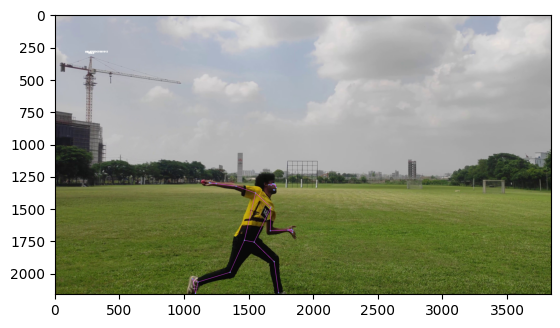

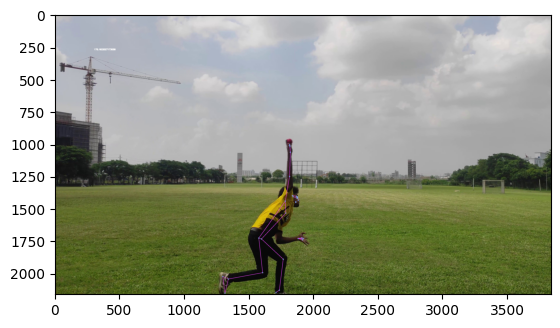

sholder: 161.62520431801912 release: 175.1922027173058
YT_Sample_22.mp4
[True, 13.566998399286689]


In [ ]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
results={}

for i in range(len(mp4_files)):
  video_path = mp4_files[i]
  cap = cv2.VideoCapture(video_path)
  image = extract(cap)
  if(image is None):
    continue

  temp_image_path = f'shoulder_frame.jpg'
  cv2.imwrite(temp_image_path, image)

  # display(Image(temp_image_path))


  cap = cv2.VideoCapture(video_path)
  img = release(cap)
  if(img is None):
    continue


  temp_image_path = f'release_frame.jpg'
  cv2.imwrite(temp_image_path, img)

  shoulder_image = cv2.imread('shoulder_frame.jpg')

  img,shoulder_angle= detect(shoulder_image)


  temp_image_path = f'shoulder_frame_out.jpg'

  if(img is None):
    continue
  cv2.imwrite(temp_image_path, img)

  release_image = cv2.imread('release_frame.jpg')
  release_img,release_angle= detect(release_image)
  if(release_angle is None):
    continue

  temp_image_path = f'release_frame_out.jpg'
  cv2.imwrite(temp_image_path, release_img)
  result = shoulder_angle-release_angle


  img=cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  plt.imshow(img)
  plt.show()
  release_img=cv2.cvtColor(release_img, cv2.COLOR_RGB2BGR)
  plt.imshow(release_img)
  plt.show()
  print("sholder: "+str(shoulder_angle)+" release: "+str(release_angle))
  print(file_list[i])
  results[file_list[i]]=[(abs(result)<=15.0) , abs(result)]
  print(results[file_list[i]])